# CNN for Trading - Part 3: Training and Evaluating a CNN

To exploit the grid-like structure of time-series data, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

An alternative approach converts a time series of alpha factors into a two-dimensional format to leverage the ability of CNNs to detect local patterns. [Sezer and Ozbayoglu (2018)](https://www.researchgate.net/publication/324802031_Algorithmic_Financial_Trading_with_Deep_Convolutional_Neural_Networks_Time_Series_to_Image_Conversion_Approach) propose CNN-TA, which computes 15 technical indicators for different intervals and uses hierarchical clustering (see Chapter 13, Data-Driven Risk Factors and Asset Allocation with Unsupervised Learning) to locate indicators that behave similarly close to each other in a two-dimensional grid.

The authors train a CNN similar to the CIFAR-10 example we used earlier to predict whether to buy, hold, or sell an asset on a given day. They compare the CNN performance to "buy-and-hold" and other models and find that it outperforms all alternatives using daily price series for Dow 30 stocks and the nine most-traded ETFs over the 2007-2017 time period.

The section on *CNN for Trading* consists of three notebooks that experiment with this approach using daily US equity price data. They demonstrate 
1. How to compute relevant financial features
2. How to convert a similar set of indicators into image format and cluster them by similarity
3. How to train a CNN to predict daily returns and evaluate a simple long-short strategy based on the resulting signals.

## Creating and training a convolutional neural network

Now we are ready to design, train, and evaluate a CNN following the steps outlined in the
previous section.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import sys, os

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
size = 15
lookahead = 1

In [7]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

In [8]:
with pd.HDFStore('data.h5') as store:
    features = store['img_data']
    targets = store['targets']

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378728 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-29 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(225)
memory usage: 2.0+ GB


In [10]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378728 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-29 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 81.8+ MB


In [11]:
outcome = f'r{lookahead:02}_fwd'
features = features.join(targets[[outcome]]).dropna()
target = features[outcome]
features = features.drop(outcome, axis=1)

## Convolutional Neural Network

We again closely follow the authors in creating a CNN with 2 convolutional layers with kernel size 3 and 16 and 32 filters, respectively, followed by a max pooling layer of size 2. 

We flatten the output of the last stack of filters and connect the resulting 1,568 outputs to a dense layer of size 32, applying 25 and 50 percent dropout probability to the incoming and outcoming connections to mitigate overfitting.

### Model Architecture

In [12]:
def make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32):
    input_shape = (size, size, 1)
    cnn = Sequential([
        Conv2D(filters=filter1,
               kernel_size=3,
               padding='same',
               activation=act1,
               input_shape=input_shape,
               name='CONV1'),
        Conv2D(filters=filter2,        
               kernel_size=3,  
               padding='same',
               activation=act2,
               name='CONV2'),
        MaxPooling2D(pool_size=2, name='POOL2'),
        Dropout(do1, name='DROP1'),
        Flatten(name='FLAT1'),
        Dense(dense, activation='relu', name='FC1'),
        Dropout(do2, name='DROP2'),
        Dense(1, activation='linear', name='FC2')
    ])
    cnn.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, 
                                                  momentum=0.9, 
                                                  nesterov=False, 
                                                  name='SGD'),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return cnn

In [13]:
cnn = make_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 15, 15, 16)        160       
_________________________________________________________________
CONV2 (Conv2D)               (None, 15, 15, 32)        4640      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 7, 7, 32)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 7, 7, 32)          0         
_________________________________________________________________
FLAT1 (Flatten)              (None, 1568)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 32)                50208     
_________________________________________________________________
DROP2 (Dropout)              (None, 32)                0

### Train the Model

We cross-validate the model with the MutipleTimeSeriesCV train and validation set index generator introduced in Chapter 7, Linear Models – From Risk Factors to Return Forecasts. We provide 5 years of trading days during the training period in batches of 64 random samples and validate using the subsequent 3 months, covering the years 2014-2017.

In [14]:
train_period_length = 5 * 12 * 21
test_period_length = 5 * 21
n_splits = 16

In [15]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

We scale the features to the range [-1, 1] and again use NumPy's .reshape() method to create the requisite format: 

In [16]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    return (x_train.reshape(-1, size, size, 1), y_train,
            x_val.reshape(-1, size, size, 1), y_val)

In [17]:
batch_size = 64

In [18]:
checkpoint_path = results_path / f'lookahead_{lookahead:02d}'
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

Training and validation follow the process laid out in Chapter 17, Deep Learning for Trading, relying on checkpointing to store weights after each epoch and generate predictions for the best-performing iterations without the need for costly retraining.

In [20]:
start = time()
ic  = []
for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
    X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
    preds = y_val.to_frame('actual')
    r = pd.DataFrame(index=y_val.index.unique(level='date')).sort_index()
    model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
    best_mean = best_median = -np.inf
    for epoch in range(25):         
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  epochs=epoch + 1,
                  initial_epoch=epoch,
                  verbose=0, shuffle=True)
        model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        preds[epoch] = model.predict(X_val).squeeze()
        r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
        print(f'{format_time(time()-start)} | {fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
    ic.append(r.assign(fold=fold))
ic = pd.concat(ic)
ic.to_csv(checkpoint_path / 'ic.csv')

00:00:14 | 01 | 01 | -0.0043 | -0.0043
00:00:25 | 01 | 02 | -0.0070 | -0.0062
00:00:36 | 01 | 03 | -0.0076 | -0.0054
00:00:46 | 01 | 04 | -0.0072 |  0.0021
00:00:57 | 01 | 05 | -0.0074 | -0.0014
00:01:08 | 01 | 06 | -0.0072 | -0.0007
00:01:18 | 01 | 07 | -0.0059 |  0.0010
00:01:29 | 01 | 08 | -0.0054 | -0.0031
00:01:40 | 01 | 09 | -0.0085 | -0.0134
00:01:52 | 01 | 10 | -0.0083 | -0.0102
00:02:04 | 01 | 11 | -0.0075 | -0.0072
00:02:15 | 01 | 12 | -0.0064 | -0.0122
00:02:25 | 01 | 13 | -0.0071 | -0.0082
00:02:37 | 01 | 14 | -0.0069 | -0.0126
00:02:48 | 01 | 15 | -0.0065 | -0.0133
00:02:59 | 01 | 16 | -0.0070 | -0.0129
00:03:10 | 01 | 17 | -0.0071 | -0.0131
00:03:21 | 01 | 18 | -0.0065 | -0.0138
00:03:32 | 01 | 19 | -0.0065 | -0.0093
00:03:44 | 01 | 20 | -0.0063 | -0.0072
00:03:55 | 01 | 21 | -0.0069 | -0.0086
00:04:06 | 01 | 22 | -0.0065 | -0.0057
00:04:17 | 01 | 23 | -0.0061 | -0.0073
00:04:29 | 01 | 24 | -0.0060 | -0.0063
00:04:41 | 01 | 25 | -0.0061 | -0.0070
00:04:53 | 02 | 01 | -0.0

00:41:48 | 09 | 12 |  0.0194 |  0.0221
00:42:02 | 09 | 13 |  0.0199 |  0.0196
00:42:15 | 09 | 14 |  0.0199 |  0.0159
00:42:28 | 09 | 15 |  0.0205 |  0.0176
00:42:49 | 09 | 16 |  0.0210 |  0.0129
00:43:14 | 09 | 17 |  0.0211 |  0.0173
00:43:37 | 09 | 18 |  0.0214 |  0.0221
00:44:00 | 09 | 19 |  0.0216 |  0.0198
00:44:23 | 09 | 20 |  0.0222 |  0.0171
00:44:46 | 09 | 21 |  0.0224 |  0.0186
00:45:09 | 09 | 22 |  0.0227 |  0.0193
00:45:30 | 09 | 23 |  0.0230 |  0.0169
00:45:43 | 09 | 24 |  0.0233 |  0.0157
00:45:54 | 09 | 25 |  0.0235 |  0.0159
00:46:07 | 10 | 01 | -0.0063 | -0.0120
00:46:19 | 10 | 02 | -0.0063 | -0.0114
00:46:31 | 10 | 03 | -0.0065 | -0.0117
00:46:43 | 10 | 04 | -0.0068 | -0.0108
00:46:55 | 10 | 05 |  0.0063 |  0.0098
00:47:07 | 10 | 06 | -0.0072 | -0.0124
00:47:20 | 10 | 07 | -0.0070 | -0.0095
00:47:32 | 10 | 08 | -0.0065 | -0.0087
00:47:44 | 10 | 09 |  0.0060 |  0.0101
00:47:55 | 10 | 10 | -0.0061 | -0.0026
00:48:07 | 10 | 11 |  0.0066 |  0.0059
00:48:19 | 10 | 12 | -0.0

### Evaluate results

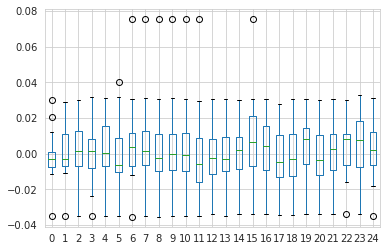

In [21]:
ic.groupby('fold').mean().boxplot();

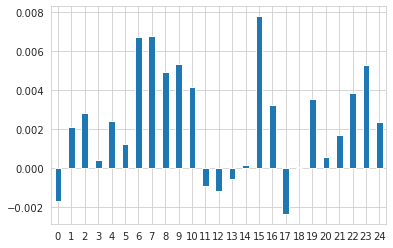

In [22]:
ic.groupby('fold').mean().mean().sort_index().plot.bar(rot=0);

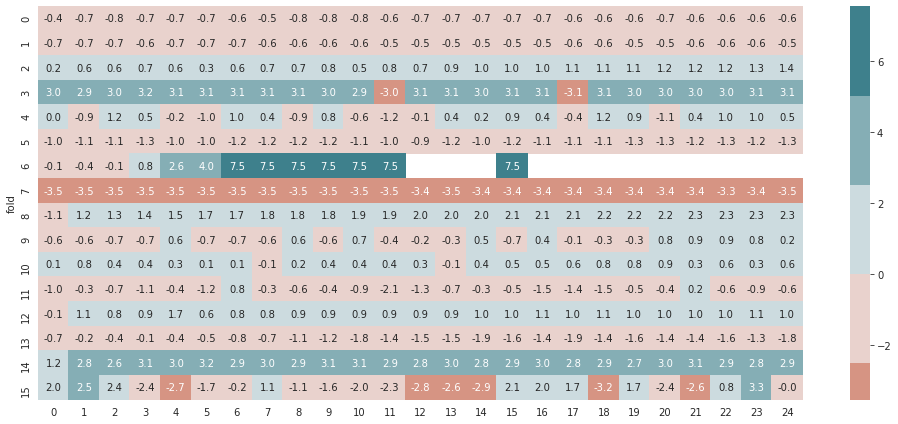

In [23]:
cmap = sns.diverging_palette(h_neg=20, h_pos=210)
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(ic.groupby('fold').mean().mul(100), ax=ax, center=0, cmap=cmap, annot=True, fmt='.1f')
fig.tight_layout()

## Make Predictions

To evaluate the model's predictive accuracy, we compute the daily information coefficient (IC) for the validation set like so:


In [24]:
def generate_predictions(epoch):
    predictions = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(features)):
        X_train, y_train, X_val, y_val = get_train_valid_data(features, target, train_idx, test_idx)
        preds = y_val.to_frame('actual')
        model = make_model(filter1=16, act1='relu', filter2=32, 
                       act2='relu', do1=.25, do2=.5, dense=32)
        status = model.load_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(X_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [25]:
preds = {}
for i, epoch in enumerate(ic.drop('fold', axis=1).mean().nlargest(5).index):
    preds[i] = generate_predictions(epoch)

In [26]:
with pd.HDFStore(results_path / 'predictions.h5') as store:
    store.put('predictions', pd.DataFrame(preds).sort_index())